Notes on adversarial examples:
 - for some reason beach is linked to frisbee

In [33]:
import os
import torch
import pickle
import numpy as np
from PIL import Image
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.nn.utils.rnn import pack_padded_sequence
from torch.nn.utils.rnn import pad_packed_sequence

In [2]:
#sample.py
from torchvision import transforms 
from build_vocab import Vocabulary

In [3]:
def load_image(image_path, transform=None):
    image = Image.open(image_path)
    image = image.resize([224, 224], Image.LANCZOS)
    
    if transform is not None:
        image = transform(image).unsqueeze(0)
    
    return image

In [4]:
class EncoderCNN(nn.Module):
    def __init__(self, embed_size):
        """Load the pretrained ResNet-152 and replace top fc layer."""
        super(EncoderCNN, self).__init__()
        resnet = models.resnet152(pretrained=True)
        modules = list(resnet.children())[:-1]      # delete the last fc layer.
        self.resnet = nn.Sequential(*modules)
        self.linear = nn.Linear(resnet.fc.in_features, embed_size)
        self.bn = nn.BatchNorm1d(embed_size, momentum=0.01)
        
    def forward(self, images):
        """Extract feature vectors from input images."""
        with torch.no_grad():
            features = self.resnet(images)
        features = features.reshape(features.size(0), -1)
        features = self.bn(self.linear(features))
        return features
    
class DecoderRNN(nn.Module):
    def __init__(self, embed_size, hidden_size, vocab_size, num_layers, max_seq_length=20):
        """Set the hyper-parameters and build the layers."""
        super(DecoderRNN, self).__init__()
        self.embed = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, batch_first=True)
        self.linear = nn.Linear(hidden_size, vocab_size)
        self.max_seg_length = max_seq_length
        
    def forward(self, features, captions, lengths):
        """Decode image feature vectors and generates captions."""
        embeddings = self.embed(captions)
        embeddings = torch.cat((features.unsqueeze(1), embeddings), 1)
        packed = pack_padded_sequence(embeddings, lengths, batch_first=True) 
        hiddens, _ = self.lstm(packed)
        hiddens = pad_packed_sequence(hiddens, batch_first=True)
        outputs = self.linear(hiddens[0])
        return outputs
    
    def sample(self, features, states=None):
        """Generate captions for given image features using greedy search."""
        sampled_ids = []
        print(features.size())
        inputs = features.unsqueeze(1)
        print(inputs.size())
        for i in range(self.max_seg_length):
            hiddens, states = self.lstm(inputs, states)          # hiddens: (batch_size, 1, hidden_size)
            outputs = self.linear(hiddens.squeeze(1))            # outputs:  (batch_size, vocab_size)
            _, predicted = outputs.max(1)                        # predicted: (batch_size)
            sampled_ids.append(predicted)
            inputs = self.embed(predicted)                       # inputs: (batch_size, embed_size)
            inputs = inputs.unsqueeze(1)                         # inputs: (batch_size, 1, embed_size)
        sampled_ids = torch.stack(sampled_ids, 1)                # sampled_ids: (batch_size, max_seq_length)
        return sampled_ids 

## Testing the currently training captioning model

In [5]:
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')

In [6]:
vocab_path = "data/vocab.pkl"
encoder_path = "models/encoder-2-1000.ckpt"
decoder_path = "models/decoder-2-1000.ckpt"

# Model parameters

embed_size = 256
hidden_size = 512
num_layers = 1

In [8]:
# Image preprocessing
transform = transforms.Compose([
    transforms.ToTensor(), 
    transforms.Normalize((0.485, 0.456, 0.406), 
                         (0.229, 0.224, 0.225))])

# Load vocabulary wrapper
with open(vocab_path, 'rb') as f:
    vocab = pickle.load(f)

# Build models

In [13]:
%%time
encoder = EncoderCNN(embed_size).eval()  # eval mode (batchnorm uses moving mean/variance)
decoder = DecoderRNN(embed_size, hidden_size, len(vocab), num_layers)
encoder = encoder.to(device)
decoder = decoder.to(device)

CPU times: user 1.32 s, sys: 486 ms, total: 1.8 s
Wall time: 1.8 s


### Load state from pre-trained models

In [17]:
%%time
encoder.load_state_dict(torch.load(encoder_path, map_location=torch.device("cpu")))
decoder.load_state_dict(torch.load(decoder_path, map_location=torch.device("cpu")))

CPU times: user 159 ms, sys: 80 ms, total: 239 ms
Wall time: 1.17 s


# Prepare an image

In [41]:
# file_path = "png/skater.png"
# file_path = "png/mountains.png"
# file_path = "png/batter.png"
# file_path = "png/two_girls_on_rock.png"
# file_path = "png/girl_on_rock.png"
file_path = "png/david.jpeg"
file_path = "png/berkay.jpeg"
file_path = "png/cat_kiss.jpeg"
# file_path = "png/kids-beach-playing-600jt082213.jpg"
image = load_image(file_path, transform)
if image.shape[2] > 3:
    image = image[:,:3]
image_tensor = image.to(device)
print(image.shape)

torch.Size([1, 3, 224, 224])


# Generate a caption from the image

### generate image features using resnet based encoder

In [42]:
%%time
feature = encoder(image_tensor)

CPU times: user 18 ms, sys: 999 µs, total: 19 ms
Wall time: 18.2 ms


In [43]:
print(image_tensor.shape)
print(feature.shape)

torch.Size([1, 3, 224, 224])
torch.Size([1, 256])


### generate caption

In [44]:
%%time
sampled_ids = decoder.sample(feature)
sampled_ids = sampled_ids[0].cpu().numpy()          # (1, max_seq_length) -> (max_seq_length)

torch.Size([1, 256])
torch.Size([1, 1, 256])
CPU times: user 8 ms, sys: 1e+03 µs, total: 9 ms
Wall time: 8.09 ms


### convert indices to words using dictionary

In [45]:
sampled_caption = []
for word_id in sampled_ids:
    word = vocab.idx2word[word_id]
    sampled_caption.append(word)
    if word == '<end>':
        break
sentence = ' '.join(sampled_caption)

# Print out the image and the generated caption

In [46]:
sentence = ' '.join(sampled_caption)
print (sentence)

<start> a cat laying on top of a bed . <end>


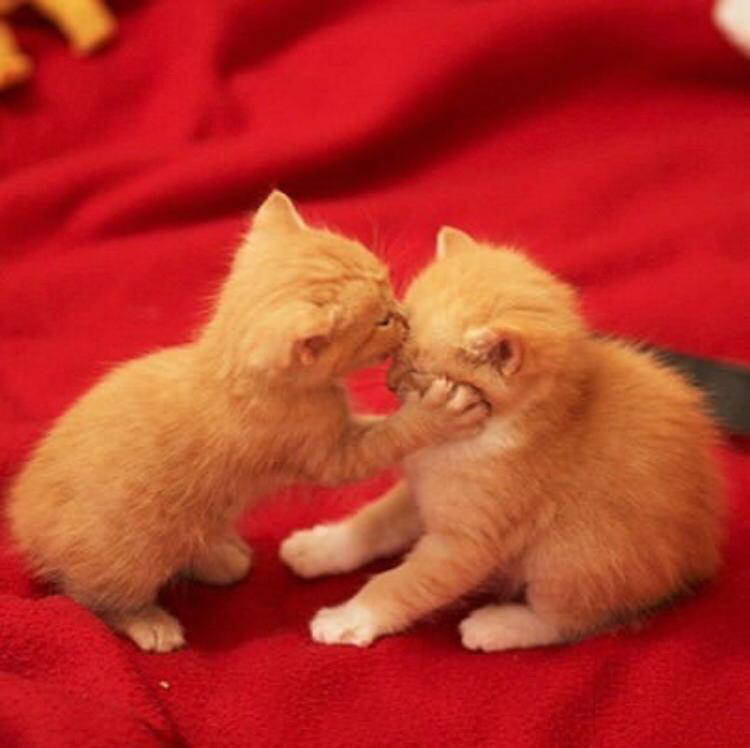

In [47]:
image = Image.open(file_path)
image